In [24]:
# /scratch2/personal/pteng/dataset/rawlung/RESEARCH/dcm/102651630/img_1.dcm
# /scratch2/personal/pteng/dataset/rawlung/RESEARCH/image/102651630.nii.gz
# /scratch2/personal/pteng/dataset/rawlung/RESEARCH/mask/102651630.nii.gz

In [69]:
import os, sys
import numpy as np
import pandas as pd
import SimpleITK as sitk
from scipy import ndimage as ndi
from skimage import filters
import matplotlib.pyplot as plt
%matplotlib inline

In [70]:
import SimpleITK as sitk

def imread(fpath):
    if fpath.endswith('.list'):
        with open(fpath,'r') as f:
            dicom_names = [x for x in f.read().split('\n') if len(x) > 0]
        if not os.path.exists(dicom_names[0]):
            dicom_names = [os.path.join(os.path.dirname(fpath),x) for x in dicom_names]
        reader = sitk.ImageSeriesReader()
        reader.SetFileNames(dicom_names)
    else:
        reader= sitk.ImageFileReader()
        reader.SetFileName(fpath)
    img = reader.Execute()
    arr = sitk.GetArrayFromImage(img)    
    spacing = img.GetSpacing()
    origin = img.GetOrigin()
    direction = img.GetDirection()
    return img

def imwrite(fpath,arr,spacing,origin,direction,use_compression=True):
    img = sitk.GetImageFromArray(arr)
    img.SetSpacing(spacing)
    img.SetOrigin(origin)
    img.SetDirection(direction)
    writer = sitk.ImageFileWriter()    
    writer.SetFileName(fpath)
    writer.SetUseCompression(use_compression)
    writer.Execute(img)

# ref https://gist.github.com/mrajchl/ccbd5ed12eb68e0c1afc5da116af614a
def resample_img(itk_image, out_spacing=[2.0, 2.0, 2.0], is_label=False):
    
    # Resample images to out_spacing with SimpleITK
    original_spacing = itk_image.GetSpacing()
    original_size = itk_image.GetSize()

    out_size = [
        int(np.round(original_size[0] * (original_spacing[0] / out_spacing[0]))),
        int(np.round(original_size[1] * (original_spacing[1] / out_spacing[1]))),
        int(np.round(original_size[2] * (original_spacing[2] / out_spacing[2])))]

    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size)
    resample.SetOutputDirection(itk_image.GetDirection())
    resample.SetOutputOrigin(itk_image.GetOrigin())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(itk_image.GetPixelIDValue())

    if is_label:
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resample.SetInterpolator(sitk.sitkBSpline)

    return resample.Execute(itk_image)

In [43]:
#img_file = '/scratch2/personal/pteng/dataset/rawlung/RESEARCH/image/102651630.nii.gz'
#mask_file = '/scratch2/personal/pteng/dataset/rawlung/RESEARCH/mask/102651630.nii.gz'
img_file = 'image.nii.gz'
mask_file = 'mask.nii.gz'

In [44]:
!ls 

Dockerfile  Untitled.ipynb  mask.nii.gz       viz-fiss.ipynb
README.md   image.nii.gz    requirements.txt


In [54]:
img_obj = imread(img_file)
mask_obj = imread(mask_file)
out_spacing = [1.0, 1.0, 1.0]
img_obj = resample_img(img_obj,out_spacing=out_spacing,is_label=False)
mask_obj = resample_img(mask_obj,out_spacing=out_spacing,is_label=True)

mask = sitk.GetArrayFromImage(mask_obj)
img = sitk.GetArrayFromImage(img_obj)
spacing = img_obj.GetSpacing()
origin = img_obj.GetOrigin()
direction = img_obj.GetDirection()

In [55]:
img.dtype,mask.dtype

(dtype('int16'), dtype('int16'))

In [56]:
print(img.shape,mask.shape)
print(spacing,origin,direction)

(280, 348, 348) (280, 348, 348)
(1.0, 1.0, 1.0) (-164.66015625, -333.16015625, 1210.0) (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, -1.0)


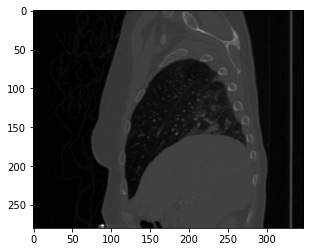

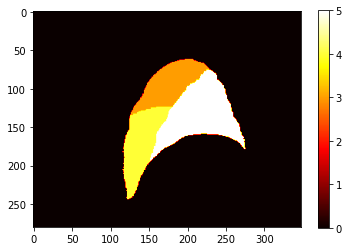

In [57]:
ind = int(1/4*img.shape[2])
plt.figure(0)
plt.imshow(img[:,:,ind],cmap='gray')
plt.figure(1)
plt.imshow(mask[:,:,ind],cmap='hot')
plt.colorbar()

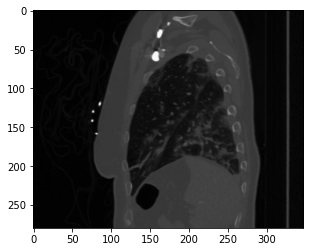

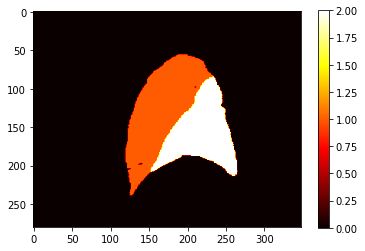

In [58]:
ind = int(3/4*img.shape[2])
plt.figure(0)
plt.imshow(img[:,:,ind],cmap='gray')
plt.figure(1)
plt.imshow(mask[:,:,ind],cmap='hot')
plt.colorbar()

In [59]:
tmp = {
    0:'bkgd',
    1:'lll',
    2:'lul',
    3:'rul',
    4:'rml',
    5:'rll',
}
print(np.unique(mask))
print(tmp)
alt_term ='''
left oblique (major) fissure (LOF)
right oblique (major) fissure (ROF) separates the lower lobe from the middle and upper lobes
the right horizontal (minor) fissure (RHF) separates the middle and upper lobes of the right lung
based on "SE Gerard et al, FissureNet: A Deep Learning Approach For Pulmonary Fissure Detection in CT Images"
'''
print(alt_term)

[0 1 2 3 4 5]
{0: 'bkgd', 1: 'lll', 2: 'lul', 3: 'rul', 4: 'rml', 5: 'rll'}

left oblique (major) fissure (LOF)
right oblique (major) fissure (ROF) separates the lower lobe from the middle and upper lobes
the right horizontal (minor) fissure (RHF) separates the middle and upper lobes of the right lung
based on "SE Gerard et al, FissureNet: A Deep Learning Approach For Pulmonary Fissure Detection in CT Images"



In [60]:
tmp = np.sum(img,axis=0)
print(tmp.shape)

(348, 348)


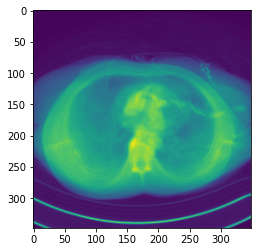

In [73]:
plt.imshow(tmp)

In [102]:
skimage.__version__

'0.17.2'

In [104]:
sigmas = list(np.arange(0.2, 1, 0.1))
print(sigmas)

[0.2, 0.30000000000000004, 0.4000000000000001, 0.5000000000000001, 0.6000000000000001, 0.7000000000000002, 0.8000000000000003, 0.9000000000000001]


In [106]:
sigmas = list(np.arange(0.2, 1, 0.1))

def get_projections(img,mask,ind0,ind1):

    if isinstance(ind0,list):
        lobe0 = np.logical_or(mask==ind0[0],mask==ind0[1])
    else:
        lobe0 = mask==ind0
        
    lobe0 = ndi.binary_dilation(lobe0,iterations=5)
    lobe0 = lobe0.astype(int)

    lobe1 = mask==ind1
    lobe1 = ndi.binary_dilation(lobe1,iterations=5)
    lobe1 = lobe1.astype(int)

    assumed_fissure_location = ((lobe0+lobe1)==2) # 10mm above and below
    del lobe0, lobe1
    
    # min,max val based on: SE Gerard, FissureNet: a deep learning approach for pulmonary fissure detection in CT images
    min_val,max_val = -1024,-200
    rescaled_img = ((img.astype(np.float)-(min_val))/(max_val-min_val)).clip(0,1)
    
    # project with sum to 2d image for visualization purpose
    img_only_fiss=rescaled_img.copy()
    img_only_fiss[assumed_fissure_location==0]=0
    intensity_proj = np.nansum(img_only_fiss,axis=0)
    del img_only_fiss # save space
    
    # old-school frangi filter
    # ref https://scikit-image.org/docs/0.15.x/api/skimage.filters.html
    # src https://github.com/scikit-image/scikit-image/blob/v0.17.2/skimage/filters/ridges.py#L357
    enhanced = filters.frangi(
        rescaled_img,
        sigmas=sigmas,
        alpha=0.1,
        beta=0.5,
        gamma=15,
        black_ridges=False)
    
    #scale_range=None,
    #scale_step=None,
    #beta1=None,
    #beta2=None,
    
    enhanced_only_fiss=enhanced.copy()
    enhanced_only_fiss[assumed_fissure_location==0]=0
    enhanced_proj = np.nansum(enhanced_only_fiss,axis=0)
    del enhanced_only_fiss # save space
    
    return intensity_proj,enhanced_proj

mylist = [
    ('lof',1,2),
    ('rof',[3,4],5),
    ('rhf',3,4),
]

mylist = [
    ('rhf',3,4),
]

mydict = {}
for n,key in enumerate(mylist):
    name,ind0,ind1 = key
    mydict[name]=get_projections(img,mask,ind0,ind1)

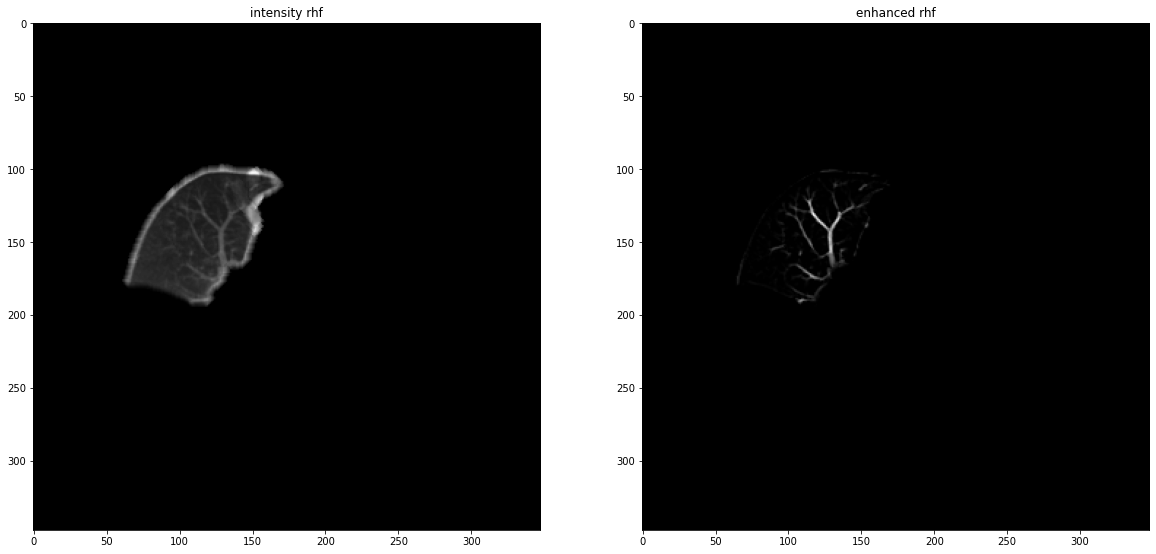

In [109]:
for n,k in enumerate(mydict.keys()):
    projected,sobeled = mydict[k]
    plt.figure(n,figsize=(20,10))
    plt.subplot(121)
    plt.title(f"intensity {k}")
    plt.imshow(projected,cmap='gray')
    plt.subplot(122)
    plt.imshow(sobeled,cmap='gray')
    plt.title(f"enhanced {k}")